<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn</h1>
</div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [2]:
from pprint import pprint

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

In [4]:
# Set numerical precision
# DTYPE = np.float64

In [5]:
# Imports for Cervino.
from cervino import *

<div class="alert alert-info">
    <h2>Cervino setup</h2>
</div>

General Cervino class which allows one to do most of the work. This class has methods to create the TOML file, the solver input file, to run the simulation, ...

In [26]:
marmousi = Cervino(name='marmousi_v15')

<div class="alert alert-info">
    <h2>Build TOML dictionary</h2>
</div>

We now build the TOML dictionary which will define the simulation. To do so, we build each section of the TOML dictionary in separate notebook cells.

<div class="alert alert-info">
    <h3>General setup</h3>
</div>

In this initial section, we define a few general parameters required by the simulation.

In [27]:
general_dict = get_general_dict(solver='matterhorn',
                                desc='Matterhorn and marmousi',
                                site='aug04')

In [28]:
# general_dict

<div class="alert alert-info">
    <h3>Domain setup</h3>
</div>

In this section, we need to define the model used for the simulation. In the example below, we choose the original Marmousi model. First thing, we need to obtain the binary files from the internet.

In [6]:
fn_h5 = utils.models.marmousi_original(solver='matterhorn', overwrite=True)

This function will fetch the Marmousi model and prepare it for the chosen solver. To do so, it will create the directory 'marmousi_original_model' in the current working directory '/work/bfilippo/cervino/notebooks'.
The existing directory '/work/bfilippo/cervino/notebooks/marmousi_original_model' has been removed.
The archive 'marmousi_archive.tar.gz' already exists.


Then, we instantiate an AcousticDomain object:

In [7]:
domain = AcousticDomain()

We then set the velocity and density models directly from the HDF5 created by the utility above:

In [8]:
# Set the models
domain.set_model_from_hdf5(fn_h5, geometry=False)

Alternatively, we can set the models from NumPy ndarrays. To do so, we need to create a dictionary with the necessary parameters:

In [9]:
geometry_dict = {
    'cell-size': (4.0, 4.0, 4.0),
    'number-of-cells': (2301, 1, 751),
    'origin': (0.0, 0.0, 0.0)
}

Then, we need to create an ndarray with the right shape:

In [10]:
num_required_models = len(domain.required_models) # Acoustic: 2
models_array = np.empty((num_required_models, geometry_dict['number-of-cells'][0], geometry_dict['number-of-cells'][2]), dtype=np.float32)
print(f"The shape of the array is {models_array.shape}")

The shape of the array is (2, 2301, 751)


In [11]:
print(f"The required models are {domain.required_models}")

The required models are ('vp', 'rho')


In [12]:
# Here we are loading the models from binary files (created by the utility above)
# to eventually recreate these binary files!
# This is only done to show how to use the set_model_from_numpy method
# The order of the models is important - See above
models_array[0, ...] = np.fromfile('marmousi_original_model/marmousi_original_vp.bin', dtype=np.float32).reshape((models_array[0, ...].shape))
models_array[1, ...] = np.fromfile('marmousi_original_model/marmousi_original_rho.bin', dtype=np.float32).reshape((models_array[0, ...].shape))

In [24]:
models_array[0, ...].shape

(2301, 751)

In [23]:
models_array[0, ...].astype('float32').tofile('prova_c.bin')

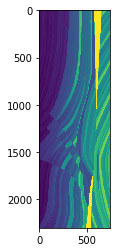

In [22]:
plt.imshow(models_array[0, ...])

In [38]:
fn_numpy_prefix = 'marmousi_numpy_original/marmousi_original'

We finally set the velocity and density models from the ndarray:

In [39]:
domain.set_model_from_numpy(models_array, geometry=geometry_dict, fn_prefix=fn_numpy_prefix, solver='matterhorn', create_hdf5=True)

marmousi_numpy_original/marmousi_original
marmousi_numpy_original/marmousi_original.h5


In [40]:
domain

In [20]:
# pprint(domain.get_domain_dict())

<div class="alert alert-info">
    <h3>Time and frequency setup</h3>
</div>

Here we need to define the time step in seconds `time_step_in_seconds` and the number of time steps `number_of_timesteps`. In the example below, we first define the time step, initial, and final time, and use these values to compute the number of time steps. However, one could also define the number of time steps directly.

In [42]:
time_step_in_seconds = 4e-4
start_time_in_seconds = 0.0
# time_shift_in_seconds = 1.0
end_time_in_seconds = 2.0

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

In [43]:
time_dict = get_time_dict(ts=time_step_in_seconds, nt=number_of_timesteps)

In [23]:
# pprint(time_dict)

<div class="alert alert-info">
    <h3>Input setup</h3>
</div>

Here, we define the input (sources) which will generate the wavefields. We can define a single point source or an array (boundary) of point sources. In the example below, we define a point source characterised by a Ricker wavelet as source time function.

In [44]:
# Use a Ricker wavelet as source time function
center_frequency = 30.0
stf = wavelets.RickerWavelet(t, fc=center_frequency, delay=1.5, delay_type='c', create_binary=True, fn_prefix='source')

Additionally, we can also load a user-defined wavelet from a binary file.

In [45]:
filename = 'user_defined_ricker_20hz.bin'
stf = UserWavelet(filename, nt=t.size)

In [46]:
# Define a point source
name = "source0"
location = (4000.0, 0.0, 20.0)
spatial_type = "fz"
scale = 1.

source0 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [47]:
# pprint(source0.get_source_dict())

In [48]:
# Plot the source time function
# This will be implemented in the PointSource class
plt.plot(t, source0.stf.wavelet)
_ = plt.title('Ricker wavelet')
_ = plt.xlabel('Time [s]')

We compute the FFT of the source time function. The values of the FFT at specific frequencies will be required later when defining DFT slice outputs.

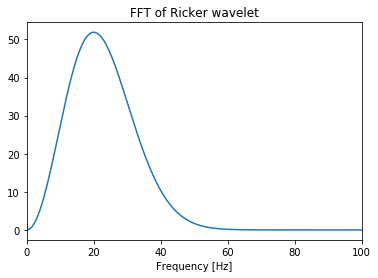

In [58]:
# Frequency step in Hz
df = 1 / (time_step_in_seconds * number_of_timesteps)
Nfft = source0.stf.wavelet.size

# Frequency axis
f = np.arange(Nfft) * df

# FFT
W = np.fft.fft(source0.stf.wavelet)

# Plot
plt.plot(f, np.abs(W))
_ = plt.title('FFT of Ricker wavelet')
_ = plt.xlabel('Frequency [Hz]')
_ = plt.xlim([0, 100])

<div class="alert alert-info">
    <h3>Output setup</h3>
</div>

Here, we definte the output of the simulation. Now we create two shot gathers:

In [59]:
# First we create a general gather object
start_timestep = 0
end_timestep = 5000
timestep_increment = 10

gather = ShotGather(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [51]:
n = domain.get_domain_dict()['geometry']['number-of-cells']
d = domain.get_domain_dict()['geometry']['cell-size']

# Number of receivers
nr = n[0]
# Receiver z-value
rz0 = 40.0
# x-value of first receiver
rx0 = 0.0
# x-value of last receiver
rx1 = nr * d[0]

In [52]:
# Then we define multiple receiver arrays
rec0 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename='vz_gather')
# rec1 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V10X', filename='vx_gather')

Additionally, we create time snapshots:

In [53]:
# First we create a general snapshot object
start_timestep = 0
end_timestep = 5000
timestep_increment = 100

snapshot = TimeSlice(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [54]:
# Axis
slice_axis = 'y'
# Slice index
slice_index = 0

In [55]:
# Then we define two slices
slice0 = snapshot.add_slices(axis=slice_axis, slice_index=slice_index, attribute='V10X', filename='vx_slice')
slice1 = snapshot.add_slices(axis=slice_axis, slice_index=slice_index, attribute='V01Z', filename='vz_slice')

Additionally, we create DFT slices:

In [60]:
# First we create a general snapshot object
dft_frequencies = list(range(5, 81, 5))

# Write wavelet coefficients to file
dft_wavelet_coefficients = np.array([W[int(i / df)] for i in dft_frequencies], dtype=np.complex64)
dft_wavelet_coefficients_fn = f"dft_wavelet_coefficients_{marmousi.name}.bin"
dft_wavelet_coefficients.tofile(dft_wavelet_coefficients_fn)
# np.array(dft_frequencies, np.float32).tofile(dft_wavelet_coefficients_fn)

dft = DFTSlice(dft_frequencies=dft_frequencies, dft_wavelet_coefficients=dft_wavelet_coefficients_fn, fmt='su')

In [61]:
# Load and print coefficients
# aa = np.fromfile(dft_wavelet_coefficients_fn, dtype=np.complex64)
# print(aa)

We define a DFT slice:

In [63]:
# Axis
slice_axis = 'y'
# Slice index
slice_index = 0

dft_slice0 = dft.add_slices(axis=slice_axis, slice_index=slice_index, attribute='S00XX', filename='sxx_dft_slice')

In [40]:
# pprint(gather.get_receivers_dict())
# pprint(snapshot.get_slices_dict())

In [65]:
# pprint(dict(zip(dft.dft_frequencies, dft_wavelet_coefficients)))

<div class="alert alert-info">
    <h3>Physics setup</h3>
</div>

We define the PML boundary conditions:

In [67]:
pml_dict = get_pml_dict(fs=True, width=10, power=4, frequency=center_frequency, vel=3000.)

We define the order of the spatial stencil:

In [68]:
physics_dict = get_physics_dict(order=4, boundaries=[pml_dict,])

In [44]:
# pprint(physics_dict)

<div class="alert alert-info">
    <h3>Assemble complete TOML dictionary</h3>
</div>

In [69]:
# Generate the complete input dictionary.
def get_input_file_dict():
    return {
        "general": general_dict,
        "domain": domain.get_domain_dict(),
        "time": time_dict,
        "physics": physics_dict,
        "source": {"point-source": [source0.get_source_dict(),]},
        "output": {
            "shot_gather": gather.get_receivers_dict(),
            "slice_time": snapshot.get_slices_dict(),
            "slice_dft": dft.get_slices_dict(),
        }
    }

input_file_dict = get_input_file_dict()

# Thoughts:
# For now, the final complete input dictionary is created manually
# joining the required smaller sectional dictionaries.
# Is there a better way to do so?

Finally, we create the input for the Cervino simulation from the complete TOML dictionary:

In [70]:
marmousi.from_dict(input_file_dict)

In [71]:
pprint(marmousi.get_input_dict())

{'domain': {'dimension': 3,
            'geometry': {'cell-size': (4.0, 4.0, 4.0),
                         'number-of-cells': (2301, 1, 751),
                         'origin': (0.0, 0.0, 0.0)},
            'model': {'filename': 'marmousi_numpy_original/marmousi_original.h5',
                      'format': 'hdf5',
                      'required-models': ('vp', 'rho')}},
 'general': {'desc': 'Matterhorn and marmousi',
             'site': 'aug04',
             'solver': 'matterhorn',
             'user': 'bfilippo'},
 'output': {'shot_gather': {'end-timestep': 5000,
                            'format': 'su',
                            'receivers': [],
                            'start-timestep': 0,
                            'timestep-increment': 10,
                            'type': 'shot_gather'},
            'slice_dft': {'dft-frequencies': [5,
                                              10,
                                              15,
                                

In [48]:
# Create the Cervino input from a TOML file
# marmousi.from_toml('marmousi_for_cervino.toml')

In [49]:
# pprint(marmousi.get_input())

In [47]:
# Look at the file we've written
# Linux
# !cat "marmousi_for_cervino.toml"
# Windows
# !type "marmousi_for_cervino.toml"

In [72]:
import toml

In [73]:
schema = toml.load('cervino_input_file_schema_test.toml')

In [74]:
pprint(schema)

{'domain': {'dimension': {'cond': 'in',
                          'example': 3,
                          'required': True,
                          'size': 1,
                          'type': 'int',
                          'value': [2, 3]},
            'geometry': {'cell-size': {'cond': 'gr',
                                       'example': [2.0, 2.0, 2.0],
                                       'required': True,
                                       'size': 3,
                                       'type': 'float',
                                       'value': 0},
                         'number-of-cells': {'cond': 'gr',
                                             'example': [500, 1, 250],
                                             'required': True,
                                             'size': 3,
                                             'type': 'int',
                                             'value': 0},
                         'origin': {'cond': 'None',


In [75]:
m = marmousi.get_input_dict()

In [76]:
schema = toml.load('cervino_input_file_schema_test.toml')

types_valid = {
    "str": str,
    "int": int,
    "float": float,
}

# conditions_valid = {
#     "in": 
# }

verbose = True

stcvre = ('size', 'type', 'cond', 'value', 'required', 'example')

for k0, v0 in schema.items():
    print(f"##############################")
    print(f"'{k0}' section")
    print(f"##############################")
    for k1, v1 in v0.items():
        print(f"------------------------------")
        print(f"'{k1}' sub-section")
        print(f"------------------------------")
#         s = v1['size']
#         t = v1['type']
#         c = v1['cond']
#         v = v1['value']
#         r = v1['required']
#         e = v1['example']
        s, t, c, v, r, e = [v1[i] for i in stcvre]
    
        # Check if the value is not required
        if k1 not in m[k0] and not r:
            print(f"This is not a required value")
            break
    
        # Replace certain values
        t = types_valid[t]
        if c == 'None':
            c = None
        if v == 'None':
            v = None
#         if r == 'True':
#             r = True
#         elif r == 'False':
#             r = False
#         else:
#             print(f"Something is wrong: 'required' can be either 'True' or 'False'")
#         s, t, c, v, r, e = v1 #.values() # This requires an OrderedDict() (?)
        if verbose:
            print(s, t, c, v, r, e)
        # Value to check (tc)
        tc = m[k0][k1]
        if verbose:
            print(f"The value to validate is '{tc}'")
        # Check size
        islist = False
        if isinstance(tc, list) and s > 1:
            islist = True
            if len(tc) != s:
                print(f"The size of the value does not match the schema")
                print(f"The current size is {len(tc)} but the size provided by the schema is {s}")
        elif not isinstance(tc, list) and s > 1:
            print(f"The schema expects a list but only a scalar was provided")
        else:
            print(f"The size is correct: {s} item(s)")
        
        # Check type
        if islist:
            for i in tc:
                if not isinstance(i, t):
                    print(f"The item {i} of the value is of the wrong type")
                    print(f"The schema expects a '{t}' but the current type is '{type(i)}'")
                else:
                    print(f"The item {i} of the value is of the correct type: {type(i)}")
        else:
            if not isinstance(tc, t):
                print(f"The value is of the wrong type")
                print(f"The schema expects a '{t}' but the current type is '{type(tc)}'")
            else:
                print(f"The value is of the correct type: {type(tc)}")
        # Check condition
        if c is not None:
            if c == 'in':
                if tc not in v:
                    print(f"The value '{tc}' is not one of the allowed ones: {v}")
                else:
                    print(f"The value '{tc}' is one of the allowed ones: {v}")
        else:
            print(f"No condition is evaluated on this value")
        # Check if required
        print(f"#### 'required': DO NOT FORGET TO IMPLEMENT THIS ####")
        # Print example
        if verbose:
            print(f"An example for this value is '{e}'")
        
    # Add a white line
    print("")

print(f"##############################")

##############################
'general' section
##############################
------------------------------
'user' sub-section
------------------------------
1 <class 'str'> None None True bfilippo
The value to validate is 'bfilippo'
The size is correct: 1 item(s)
The value is of the correct type: <class 'str'>
No condition is evaluated on this value
#### 'required': DO NOT FORGET TO IMPLEMENT THIS ####
An example for this value is 'bfilippo'
------------------------------
'site' sub-section
------------------------------
1 <class 'str'> None None True aug04
The value to validate is 'aug04'
The size is correct: 1 item(s)
The value is of the correct type: <class 'str'>
No condition is evaluated on this value
#### 'required': DO NOT FORGET TO IMPLEMENT THIS ####
An example for this value is 'aug04'
------------------------------
'desc' sub-section
------------------------------
1 <class 'str'> None None True Master TOML file
The value to validate is 'Matterhorn and marmousi'
The size 

<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

This launches the simulation on the local workstation/laptop.

In [53]:
# mh_file = marmousi.to_solver_input()

In [54]:
# mh_file

In [55]:
# !cat marmousi_v15.sim

We first need to define a small dictionary with a few required parameters:

In [77]:
run_dict = {
    'solver_binary': 'matterhorn',
    'progress': True,
    'verbose': False,
    'ncores': 24
}

Before running the simulation, we want to validate its input to make sure it is correct:

In [78]:
marmousi.validate()

In [80]:
result = marmousi.run(run_dict)

In [79]:
marmousi._site

'local'

<div class="alert alert-info">
    <h3>Matterhorn (Euler)</h3>
</div>


* Create submission script
* Copy the file to Euler
* Submit the job to the queue
* Obtain the JOB ID
* Check the status of the job
* If the job is running, start the progress bar
* Retrive the output files

## Important!
This section requires that the model files are already on Euler. I will modify this soon.

In [ ]:
run_dict = {
    'solver_binary': 'matterhorn',
    'progress': True,
    'verbose': False,
    'ncores': 24,
    'dir_remote': '/cluster/scratch/bfilippo/cervino',
    'fn_submission_script': 'script.sh',
    'job_name': marmousi.name,
}

In [ ]:
run_dict

In [ ]:
jobid = marmousi.run(run_dict)

In [ ]:
bjobs_dict = marmousi.check_status()

In [ ]:
pprint(bjobs_dict)

In [ ]:
bjobs_dict = marmousi.fetch(dir_local='./euler')

<div class="alert alert-info">
    <h2>Pipeline</h2>
</div>

<div class="alert alert-info">
    <h3>2D line</h3>
</div>

In [ ]:
# Define a list of source locations
# source_locations = [(2000.0, 0.0, 20.0), (4000.0, 0.0, 20.0), (6000.0, 0.0, 20.0)]
source_locations = [(float(x), 0.0, 20.0) for x in range(2000, 6000, 2000)]
pprint(source_locations)

In [ ]:
# Create the Pipeline object
marmousi_pipeline = Pipeline(marmousi)

In [ ]:
# TO DO:
# 1) Create many input files DONE
# 2) Change the source location DONE
# 3) Add a suffix at the end of the filename_prefix of the outputs DONE
# 4) Keep track of the input files and the output files DONE

from collections import OrderedDict

pipeline_dict = OrderedDict()
# Specify the task: create a 2D line of shot gather
pipeline_dict['2d_line'] = source_locations

marmousi_2d_line = marmousi_pipeline.create(pipeline_dict)

In [ ]:
marmousi_pipeline

In [ ]:
# Execute the pipeline
marmousi_pipeline.run()

<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

In [81]:
filename = 'vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

True

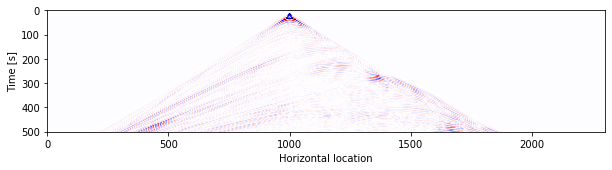

In [82]:
clip = 1e-9
vmin, vmax = -clip, clip

# Figure
figsize=(10, 15)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [83]:
sufile.close()

<div class="alert alert-info">
    <h2>Convert output to HDF5</h2>
</div>

In [84]:
import h5py

In [85]:
from pathlib import Path

In [86]:
fn = f'{marmousi.name}.h5'
print(fn)

marmousi_v15.h5


In [87]:
marmousi.convert_output_to_hdf5()

Unable to create group (name already exists)


'marmousi_v15.h5'

In [88]:
outputs = marmousi.get_output_files()
pprint(outputs)

{'slice_dft_000': ('slice_dft', 'sxx_dft_slice'),
 'slice_time_000': ('slice_time', 'vx_slice'),
 'slice_time_001': ('slice_time', 'vz_slice')}


In [89]:
for output_k, output_v in outputs.items():
    print(output_v[0])
    print(output_v[1])

slice_time
vx_slice
slice_time
vz_slice
slice_dft
sxx_dft_slice


In [91]:
with h5py.File(fn, 'r') as f:
    print(type(f.attrs['groups']))
    print(f.attrs['groups'].dtype)
    print(f.attrs['groups'])
    print(type(f['slice_dft'].attrs['dft_frequencies']))
    b = f['slice_dft'].attrs['datasets']
    print(type(b))
    print(b.dtype)
    print(b)
    a = np.array(['ciao', 'ciaone'])
    print(a)
    print(a.dtype)
#     f['slice_dft'].attrs['datasets'] = a

<class 'numpy.ndarray'>
object
['slice_time' 'slice_dft']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
object
['sxx_dft_slice']
['ciao' 'ciaone']
<U6


In [92]:
# print(fn)
with h5py.File(fn, 'r') as f:
    for item in f.keys():
        print(list(f[item].attrs['datasets']))
#         print(type(item))

['sxx_dft_slice']
['vx_slice', 'vz_slice']


In [93]:
with h5py.File(fn, 'r') as f:
#     for item in f.attrs.keys():
#         print(item)
    print(f.attrs['groups'])

['slice_time' 'slice_dft']


In [94]:
with h5py.File(fn, 'r') as f:
    pprint(f['slice_time'].attrs['datasets'])

array(['vx_slice', 'vz_slice'], dtype=object)


marmousi_v15.h5


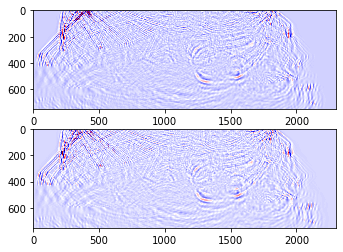

In [95]:
print(fn)
with h5py.File(fn, 'r') as f:
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax[0].imshow(f['slice_dft']['sxx_dft_slice'][12].real, cmap=plt.cm.seismic)
    ax[1].imshow(f['slice_dft']['sxx_dft_slice'][12].imag, cmap=plt.cm.seismic)

marmousi_v15.h5


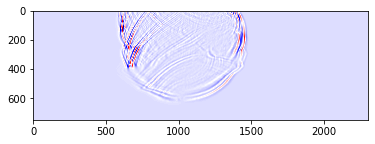

In [96]:
print(fn)
with h5py.File(fn, 'r') as f:
    plt.imshow(f['slice_time']['vx_slice'][27].T, cmap=plt.cm.seismic)